In [ ]:
# Forecasting use LSTM For AQI (AIR QUALITY INDEX) Based on PM10

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [3]:
# Import Dataset
dataset = pd.read_csv('ispu_data.csv')

# Select column
cols = list(dataset)[1:4]

# Extracting
datelist = list(dataset['tanggal'])
datelist = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist]

print('Training set shape = {}'.format(dataset.shape))
print('All timestamp = {}'.format(len(datelist)))
print('Columns Selected : {}'.format(cols))

Training set shape = (1076, 10)
All timestamp = 1076
Columns Selected : ['pm10', 'so2', 'co']


In [4]:
# DATA PREPROCESSING
dataset = dataset[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset)):
        dataset[i][j] = dataset[i][j].replace(',', '')

dataset = dataset.astype(float)
# Using feature columns
training_set = dataset.values

print('Shape of training set = {}.'.format(training_set.shape))
training_set

Shape of training set = (1076, 3).


array([[29., 15.,  7.],
       [24., 17.,  6.],
       [23., 16.,  6.],
       ...,
       [61., 54., 15.],
       [60., 53., 17.],
       [64., 52., 44.]])

In [5]:
# Feature Scale
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
training_set_scaled = scaler.fit_transform(training_set)

scaler_predict = StandardScaler()
scaler_predict.fit_transform(training_set[:, 0:1])

array([[-2.1921057 ],
       [-2.52555766],
       [-2.59224805],
       ...,
       [-0.0580132 ],
       [-0.12470359],
       [ 0.14205797]])

In [31]:
# Create data structure 60 timestamps and 1 output
x_train = []
y_train = []

n_future = 250
n_past = 400

for i in range(n_past, len(training_set_scaled) - n_future + 1):
    x_train.append(training_set_scaled[i - n_past:i, 0:dataset.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

print('x_train shape = {}.'.format(x_train.shape))
print('y_train shape = {}.'.format(y_train.shape))

x_train shape = (427, 400, 2).
y_train shape = (427, 1).


In [32]:
# LSTM Model
model = Sequential()
# 1st LSTM layer
#model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset.shape[1]-1)))
model.add(LSTM(units=4, input_shape=(n_past, dataset.shape[1]-1)))
# 2nd LSTM layer
#model.add(LSTM(units=10, return_sequences=False))
# Dropout
#model.add(Dropout(0.25))
# Output layer
model.add(Dense(units=1))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 4)                 112       
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Training Model

es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(x_train, y_train, shuffle=True, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.9131
Epoch 1: val_loss improved from inf to 1.75050, saving model to weights.h5
2/2 [==============================] - 12s 3s/step - loss: 0.9131 - val_loss: 1.7505 - lr: 0.0100
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.8771
Epoch 2: val_loss did not improve from 1.75050
2/2 [==============================] - 1s 714ms/step - loss: 0.8771 - val_loss: 1.7606 - lr: 0.0100
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.8548
Epoch 3: val_loss did not improve from 1.75050
2/2 [==============================] - 1s 638ms/step - loss: 0.8548 - val_loss: 1.7794 - lr: 0.0100
Epoch 4/100
2/2 [==============================] - ETA: 0s - loss: 0.8442
Epoch 4: val_loss did not improve from 1.75050
2/2 [==============================] - 1s 616ms/step - loss: 0.8442 - val_loss: 1.7939 - lr: 0.0100
Epoch 5/100
2/2 [==============================] - ETA: 0s - loss: 0.8383
Epoch 5: val_los

In [35]:
# Future Prediction
datelist_future = pd.date_range(datelist[-1], periods=n_future, freq='1d').tolist()
datelist_future_ = []
for present_timestamp in datelist_future:
    datelist_future_.append(present_timestamp.date())

In [36]:
# Predictions
predictions_future = model.predict(x_train[-n_future:])
predictions_train = model.predict(x_train[n_past:])

1/1 [==============================] - 0s 113ms/step


In [37]:
# Inverse Pred
def datetime_to_timestamp(x):
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')

y_pred_future = scaler_predict.inverse_transform(predictions_future)
y_pred_train = scaler_predict.inverse_transform(predictions_train)

PRED_FUTURE = pd.DataFrame(y_pred_future, columns=['pm10']).set_index(pd.Series(datelist_future))
PRED_TRAIN = pd.DataFrame(y_pred_train, columns=['pm10']).set_index(pd.Series(datelist[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PRED_TRAIN.index = PRED_TRAIN.index.to_series().apply(datetime_to_timestamp)

PRED_TRAIN.head(10)

,pm10
2021-12-05,61.345890
2021-12-06,60.797276
2021-12-07,60.425049
2021-12-08,59.384174
2021-12-09,59.262241
2021-12-10,59.060661
2021-12-11,59.370705
2021-12-12,59.073898
2021-12-13,58.939175
2021-12-14,57.312096


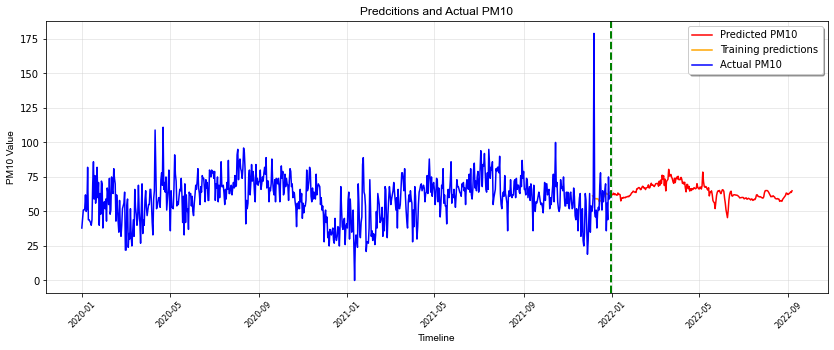

In [40]:
# Plotting

# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2020-01-01'

plt.plot(PRED_FUTURE.index, PRED_FUTURE['pm10'], color='r', label='Predicted PM10')
plt.plot(PRED_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PRED_TRAIN.loc[START_DATE_FOR_PLOTTING:]['pm10'], color='orange', label='Training predictions')
plt.plot(dataset.loc[START_DATE_FOR_PLOTTING:].index, dataset.loc[START_DATE_FOR_PLOTTING:]['pm10'], color='b', label='Actual PM10')

plt.axvline(x = min(PRED_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Actual PM10', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('PM10 Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [39]:
dataset = pd.DataFrame(dataset, columns=cols)
dataset.index = datelist
dataset.index = pd.to_datetime(dataset.index)


In [41]:
PRED_FUTURE['pm10']

2021-12-31    62.842209
2022-01-01    62.030476
2022-01-02    62.291878
2022-01-03    63.252262
2022-01-04    62.114658
                ...    
2022-09-02    63.028492
2022-09-03    63.347496
2022-09-04    64.162727
2022-09-05    63.808189
2022-09-06    64.985497
Name: pm10, Length: 250, dtype: float32

In [42]:
PRED_FUTURE['pm10'].to_csv("pm10prediction.csv")